<a href="https://colab.research.google.com/github/MWFK/TimeSeries_Sequence_with_TensorFlow/blob/main/9.%20Notebook7Code_with_Notebook8Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting With Tensorflow: Comparing Model Architectures

Notebook 7 is from kaggle, and notebook 8 is from Tf Exam, and this notebook combines the notebook 7 code with noetbook 8 data.

### Libs & Data

In [1]:
import zipfile
import urllib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
# This function downloads and extracts the dataset.
def download_and_extract_data():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/certificate/household_power.zip'
    urllib.request.urlretrieve(url, 'household_power.zip')
    with zipfile.ZipFile('/content/household_power.zip', 'r') as zip_ref:
        zip_ref.extractall()

download_and_extract_data()

In [7]:
def load_data(col=None, path='/content/household_power_consumption.csv', verbose=False):
    df = pd.read_csv(path, sep=',',infer_datetime_format=True, index_col='datetime', header=0)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

cols=['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
multivar_df = load_data(cols)
print(multivar_df.shape)
multivar_df.head()

(86400, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Data Engineering

In [9]:
def clean_data(series):
    return series.interpolate(method='linear')

def min_max_scale(dataframe):
    return MinMaxScaler().fit_transform(dataframe)

def split_data(series, train_fraq, test_len=8760):
    """
    Splits input series into train, val and test.
    Default to 1 year of test data.
    """
    # Slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]

    # Make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)

    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]

    return train_data, val_data, test_data

multivar_df = clean_data(multivar_df)

# Scale
multivar_df = min_max_scale(multivar_df)
train_multi, val_multi, test_multi = split_data(multivar_df, train_fraq=0.65, test_len=8760)
print("Multivarate Datasets")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")

print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
print(f"Nulls In Test {np.any(np.isnan(test_multi))}")

Multivarate Datasets
Train Data Shape: (50466, 7)
Val Data Shape: (27174, 7)
Test Data Shape: (8760, 7)
Nulls In Train False
Nulls In Validation False
Nulls In Test False


### Windowing the Dataset

Use tf.dataset to create a window dataset. This is a vector of past timesteps (n_steps) that is used to predict on a target vector of future steps (n_horizon).

The example below shows the output for n_steps = 72 and n_horizon = 24 and the 5 features. So we use the last 3 days (72 hours) to predict the next day (following 24 hours).

The resulting shape for X will be (batch size, n_steps, features) and Y will be (batch size, n_horizon, features).

In [10]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """
    Create a windowed tensorflow dataset
    """

    # create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon

    # expand dimensions to 3D to fit with LSTM inputs
    # create the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)           # Convert the 2D DataFrame to 3D Tensor => from (table, rows, columns) to (rows, columns, 1) ==> From (17097, 5) to (17097, 5, 1)
        ds = tf.data.Dataset.from_tensor_slices(ds)  # Create a tensor => from (17097, 5, 1) to (5,1)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data) # Create a tensor

    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)

    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer) # The method shuffles the samples in the dataset. The buffer_size is the number of samples which are randomized and returned as tf.Dataset.

    #create the supervised learning problem x and y and batch
    if multi_var:
        # x[:-n_horizon]     == x[All batches except for the last one]                ==> X
        # x[-n_horizon:, :1] == x[The Last batch of the feature, 'total load actual'] ==> y
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        # x[:-n_horizon] == x[All batches except for the last one] ==> X
        # x[-n_horizon:] == x[The Last batch]                      ==> y
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))

    ds = ds.batch(batch_size).prefetch(1)

    return ds

In [11]:
tf.random.set_seed(42)

n_steps = 24
n_horizon = 24
batch_size = 1
shuffle_buffer = 100

ds = window_dataset(train_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True)

print('Example sample shapes')
for idx,(x,y) in enumerate(ds):
    print("x = ", x.numpy().shape) # (1, 72, 5) 1 is the added dimension to fit the LSTM input(batch); 72 is the number of hours in 3 days; 5 is the number of features
    print("y = ", y.numpy().shape) # (1, 25, 1) 1 is the added dimension to fit the LSTM input(batch); 24 is the number of hours to be predicted; 1 is the target features
    break

Example sample shapes
x =  (1, 24, 7)
y =  (1, 24, 1)


In [12]:
def build_dataset(train_fraq=0.65, n_steps=24*1, n_horizon=24, batch_size=256, shuffle_buffer=500, expand_dims=False, multi_var=False):
    """
    If multi variate then first column is always the column from which the target is contstructed.
    """

    tf.random.set_seed(23)

    if multi_var:
        data = load_data(cols)
    else:
        data = load_data(cols)

    data = clean_data(data)

    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)

    train_data, val_data, test_data = split_data(data, train_fraq=train_fraq, test_len=8760)

    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)


    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = build_dataset(multi_var=True)

Prediction lookback (n_steps): 24
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


### Model Configurations

Define a set of model configurations so that we can call and run each model in the same way. The cgf_model_run dictionary will store the model, its history, and the test datasetset generated.

The default model parameters are:

    n_steps: last 30 days
    n_horizon: next 24 hours
    learning rate: 3e-4



In [13]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=24*1
    n_horizon=24
    if multivar:
        n_features=7
    else:
        n_features=1
    return n_steps, n_horizon, n_features, lr


model_configs = dict()
def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

# Define Each Model

## DNN
A single 128 unit layer plus the common 128 and 24 unit layyers with dropout.

In [14]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')

    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)

    model.compile(loss=loss, optimizer='adam', metrics=['mae'])

    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 168)               0         
                                                                 
 dense (Dense)               (None, 128)               21632     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 41,240
Trainable params: 41,240
Non-trainable par

## CNN
Two Conv 1D layers with 64 filters each, and kernel sizes of 6 and 3 respectively. After each Conv1D layer a maxpooling1D layer with size of 2.

In [15]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):

    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")

    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)

    model.compile(loss=loss, optimizer='adam', metrics=['mae'])

    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 64)            2752      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dropout (Dropout)           (None, 192)               0       

## LSTM
Two LSTM layers with 72 and 48 units each.

In [16]:
def lstm_model(n_steps, n_horizon, n_features, lr):

    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')

    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)

    model.compile(loss=loss, optimizer='adam', metrics=['mae'])

    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 72)            23040     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3096   

## CNN and LSTM Stacked
Using the same layers from the CNN and LSTM model, stack the CNN as input to the pair of LSTMs.

In [17]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):

    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")

    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)

    model.compile(loss=loss, optimizer='adam', metrics=['mae'])

    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 64)            2752      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 3, 72)             39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

## CNN and LSTM with a skip connection
The same CNN and LSTM layers as the previous models this time with a skip connection direct to the common DNN layer.

In [18]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):

    tf.keras.backend.clear_session()

    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')

    conv1 = tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)

    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)

    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')

    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)

    model.compile(loss=loss, optimizer='adam', metrics=['mae'])

    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 24, 7)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 19, 64)       2752        ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 9, 64)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 7, 64)        12352       ['max_pooling1d[0][0]']          
                                                                                          

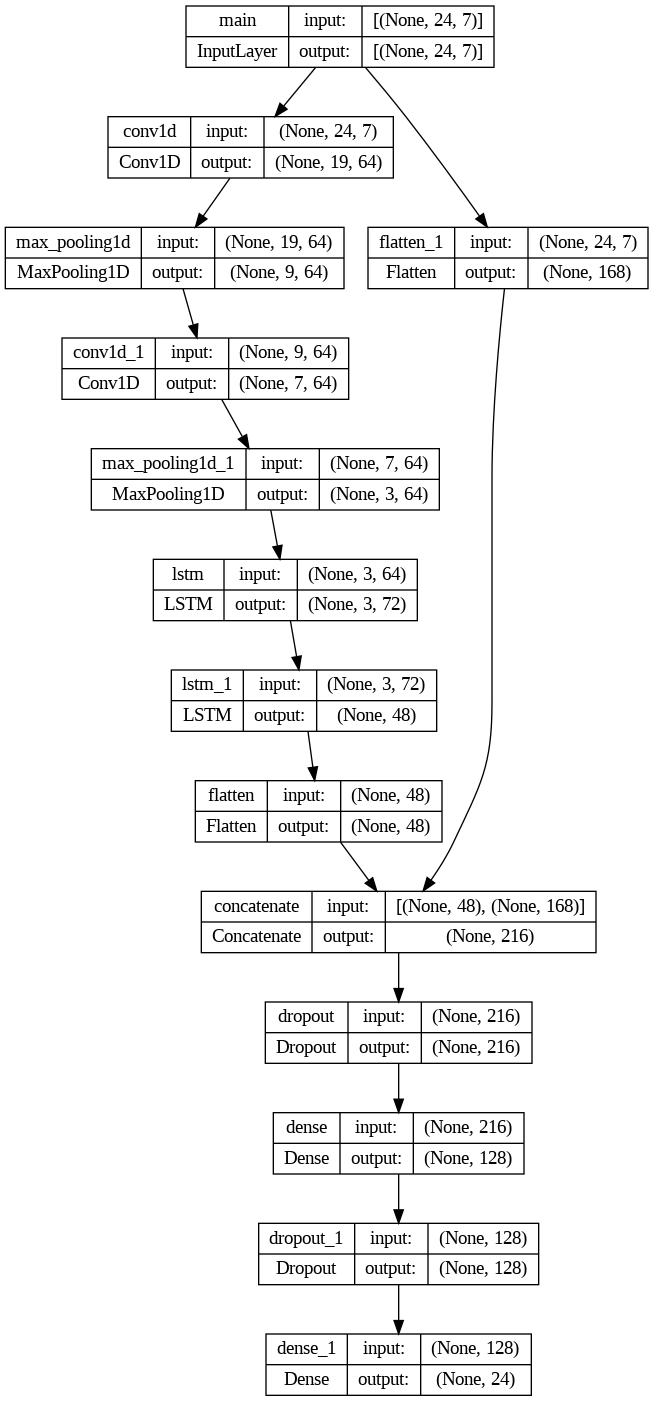

In [19]:
tf.keras.utils.plot_model(lstm_skip, show_shapes=True)

# Train Models
Run each model for 150 epochs.

In [24]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=150)
run_model("cnn", cnn_model, model_configs, epochs=150)
run_model("lstm", lstm_model, model_configs, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=150)

Prediction lookback (n_steps): 24
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
9/9 [==============================] - 2s 152ms/step - loss: 0.0492 - mae: 0.2334 - val_loss: 0.0121 - val_mae: 0.1106
Epoch 2/150
9/9 [==============================] - 1s 128ms/step - loss: 0.0169 - mae: 0.1368 - val_loss: 0.0083 - val_mae: 0.0879
Epoch 3/150
9/9 [==============================] - 1s 148ms/step - loss: 0.0119 - mae: 0.1125 - val_loss: 0.0068 - val_mae: 0.0782
Epoch 4/150
9/9 [==============================] - 1s 115ms/step - loss: 0.0093 - mae: 0.0970 - val_loss: 0.0056 - val_mae: 0.0702
Epoch 5/150
9/9 [==============================] - 1s 79ms/step - loss: 0.0080 - mae: 0.0884 - val_loss: 0.0055 - val_mae: 0.0683
Epoch 6/150
9/9 [==============================] - 1s 56ms/step - loss: 0.0072 - mae: 0.0820 - val_loss: 0.0049 - val_mae:

Epoch 1/150
9/9 [==============================] - 2s 89ms/step - loss: 0.0255 - mae: 0.1660 - val_loss: 0.0086 - val_mae: 0.0955
Epoch 2/150
9/9 [==============================] - 1s 74ms/step - loss: 0.0104 - mae: 0.1062 - val_loss: 0.0058 - val_mae: 0.0736
Epoch 3/150
9/9 [==============================] - 1s 58ms/step - loss: 0.0077 - mae: 0.0852 - val_loss: 0.0057 - val_mae: 0.0741
Epoch 4/150
9/9 [==============================] - 1s 60ms/step - loss: 0.0069 - mae: 0.0813 - val_loss: 0.0053 - val_mae: 0.0703
Epoch 5/150
9/9 [==============================] - 1s 74ms/step - loss: 0.0063 - mae: 0.0763 - val_loss: 0.0053 - val_mae: 0.0692
Epoch 6/150
9/9 [==============================] - 1s 75ms/step - loss: 0.0062 - mae: 0.0760 - val_loss: 0.0052 - val_mae: 0.0681
Epoch 7/150
9/9 [==============================] - 1s 59ms/step - loss: 0.0059 - mae: 0.0724 - val_loss: 0.0051 - val_mae: 0.0679
Epoch 8/150
9/9 [==============================] - 1s 99ms/step - loss: 0.0058 - mae: 0.07

Prediction lookback (n_steps): 24
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
9/9 [==============================] - 4s 141ms/step - loss: 0.0216 - mae: 0.1517 - val_loss: 0.0125 - val_mae: 0.1105
Epoch 2/150
9/9 [==============================] - 1s 108ms/step - loss: 0.0133 - mae: 0.1238 - val_loss: 0.0076 - val_mae: 0.0920
Epoch 3/150
9/9 [==============================] - 1s 114ms/step - loss: 0.0091 - mae: 0.1019 - val_loss: 0.0060 - val_mae: 0.0821
Epoch 4/150
9/9 [==============================] - 1s 103ms/step - loss: 0.0074 - mae: 0.0907 - val_loss: 0.0052 - val_mae: 0.0733
Epoch 5/150
9/9 [==============================] - 1s 107ms/step - loss: 0.0064 - mae: 0.0820 - val_loss: 0.0048 - val_mae: 0.0698
Epoch 6/150
9/9 [==============================] - 1s 102ms/step - loss: 0.0059 - mae: 0.0767 - val_loss: 0.0046 - val_ma

Epoch 1/150
9/9 [==============================] - 4s 106ms/step - loss: 0.0216 - mae: 0.1512 - val_loss: 0.0135 - val_mae: 0.1155
Epoch 2/150
9/9 [==============================] - 1s 70ms/step - loss: 0.0134 - mae: 0.1269 - val_loss: 0.0085 - val_mae: 0.1041
Epoch 3/150
9/9 [==============================] - 1s 80ms/step - loss: 0.0098 - mae: 0.1104 - val_loss: 0.0076 - val_mae: 0.0958
Epoch 4/150
9/9 [==============================] - 1s 126ms/step - loss: 0.0086 - mae: 0.1039 - val_loss: 0.0065 - val_mae: 0.0892
Epoch 5/150
9/9 [==============================] - 1s 113ms/step - loss: 0.0076 - mae: 0.0945 - val_loss: 0.0059 - val_mae: 0.0818
Epoch 6/150
9/9 [==============================] - 1s 80ms/step - loss: 0.0068 - mae: 0.0870 - val_loss: 0.0057 - val_mae: 0.0769
Epoch 7/150
9/9 [==============================] - 1s 63ms/step - loss: 0.0063 - mae: 0.0813 - val_loss: 0.0053 - val_mae: 0.0736
Epoch 8/150
9/9 [==============================] - 1s 80ms/step - loss: 0.0059 - mae: 0

Epoch 1/150
9/9 [==============================] - 4s 119ms/step - loss: 0.0816 - mae: 0.3080 - val_loss: 0.0147 - val_mae: 0.1289
Epoch 2/150
9/9 [==============================] - 1s 71ms/step - loss: 0.0375 - mae: 0.2120 - val_loss: 0.0109 - val_mae: 0.1075
Epoch 3/150
9/9 [==============================] - 1s 83ms/step - loss: 0.0229 - mae: 0.1644 - val_loss: 0.0113 - val_mae: 0.1055
Epoch 4/150
9/9 [==============================] - 1s 83ms/step - loss: 0.0168 - mae: 0.1387 - val_loss: 0.0093 - val_mae: 0.0926
Epoch 5/150
9/9 [==============================] - 1s 83ms/step - loss: 0.0136 - mae: 0.1220 - val_loss: 0.0089 - val_mae: 0.0903
Epoch 6/150
9/9 [==============================] - 1s 82ms/step - loss: 0.0118 - mae: 0.1114 - val_loss: 0.0077 - val_mae: 0.0835
Epoch 7/150
9/9 [==============================] - 1s 84ms/step - loss: 0.0107 - mae: 0.1035 - val_loss: 0.0077 - val_mae: 0.0846
Epoch 8/150
9/9 [==============================] - 1s 66ms/step - loss: 0.0096 - mae: 0.0

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

# Evaluation of Training/Validation Results

Loss curves across the models are fairly stable. All models show a flat validation curve while training continues to decline. The LSTM appears to begin to become very overfit from about epoch 100 where the validation loss begins to rise. The lstm_skip also has a point around epoch 50 where the val loss stops decreasing. In all cases this is a sign the models are no longer learning against the validation set. Some options to help improve this are to introduce learning rate decline, or train on longer input sequences.

Plots of the MAE show a similar pattern to the loss plots.


Loss Curves


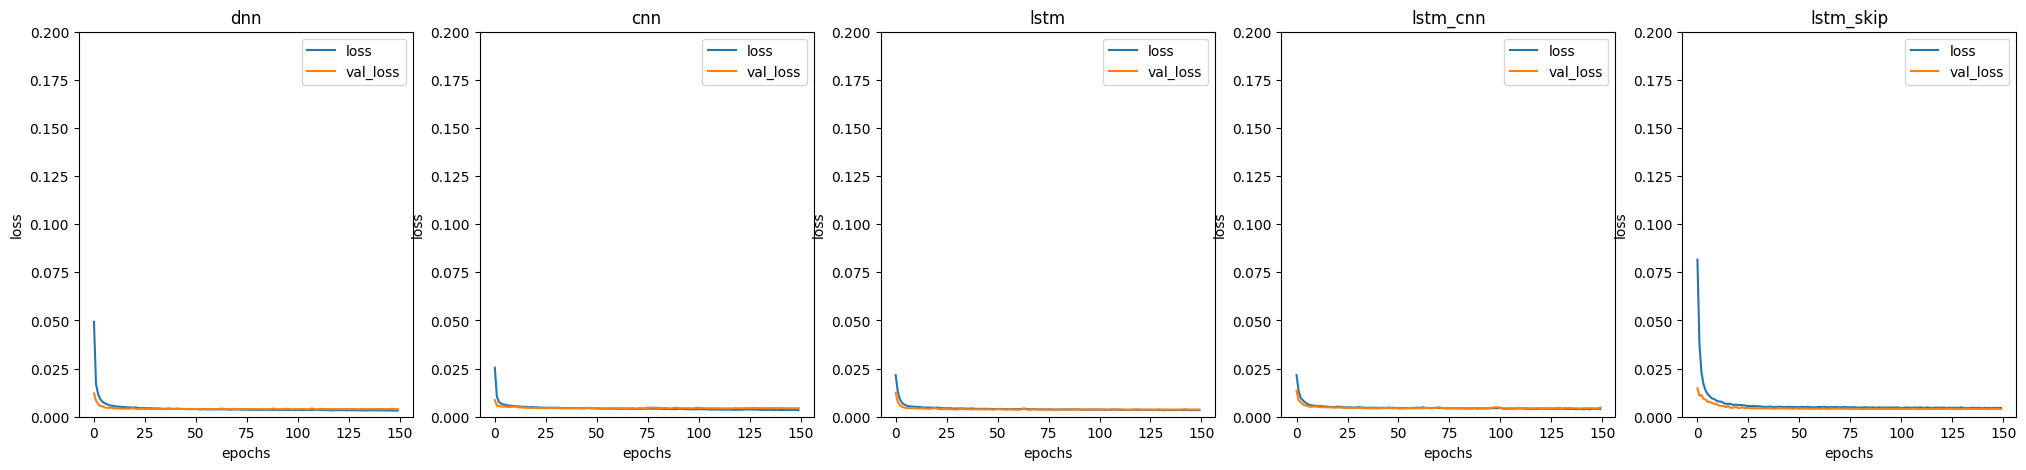

In [25]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])

for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


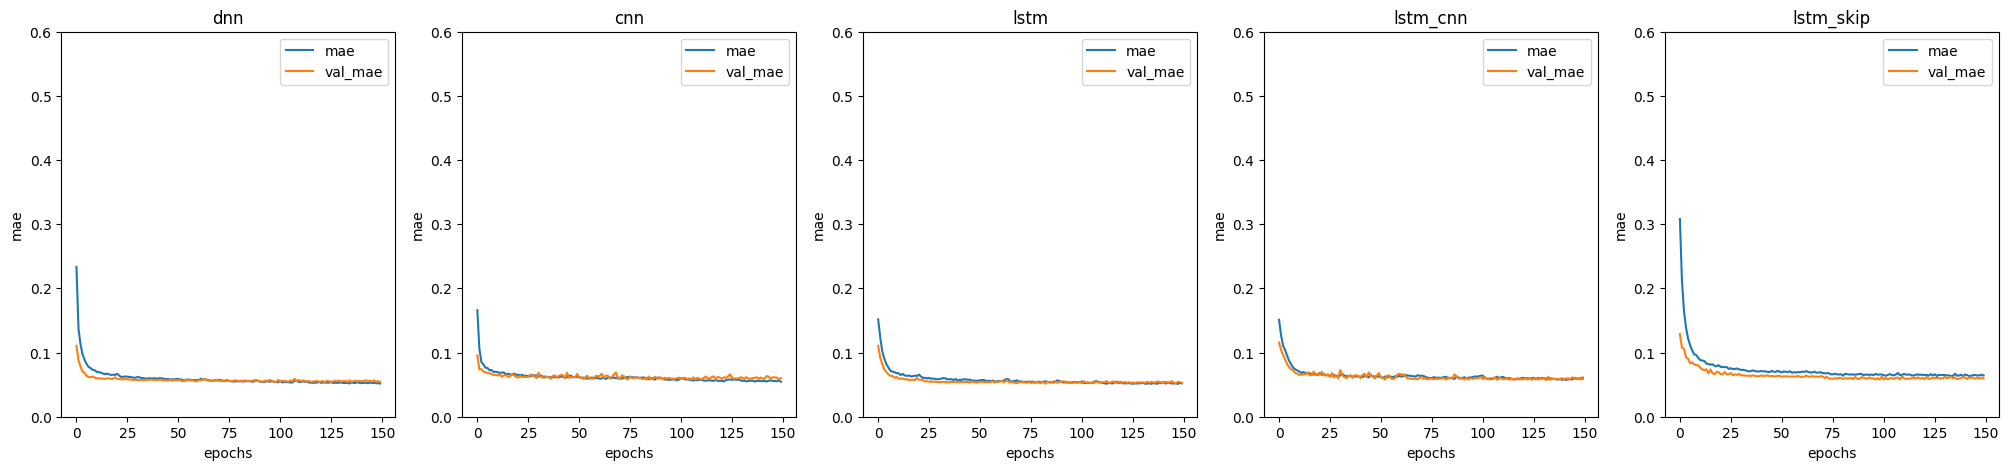

In [26]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

# Visualizing Predictions

Plot the actual and predicted 24 hour intervals. Below is the first 14 days of predictions. Interesting to note how the LSTM appears to oscilate over a longer frequency compared with the other models. The CNN also seems to capture the intra day oscillations (within the 24 hour period). Looking at the CNN stacked LSTM we can see how these two characteristics of the model's learning combine.

2/2 [==============================] - 0s 21ms/step
First Two Weeks of Predictions


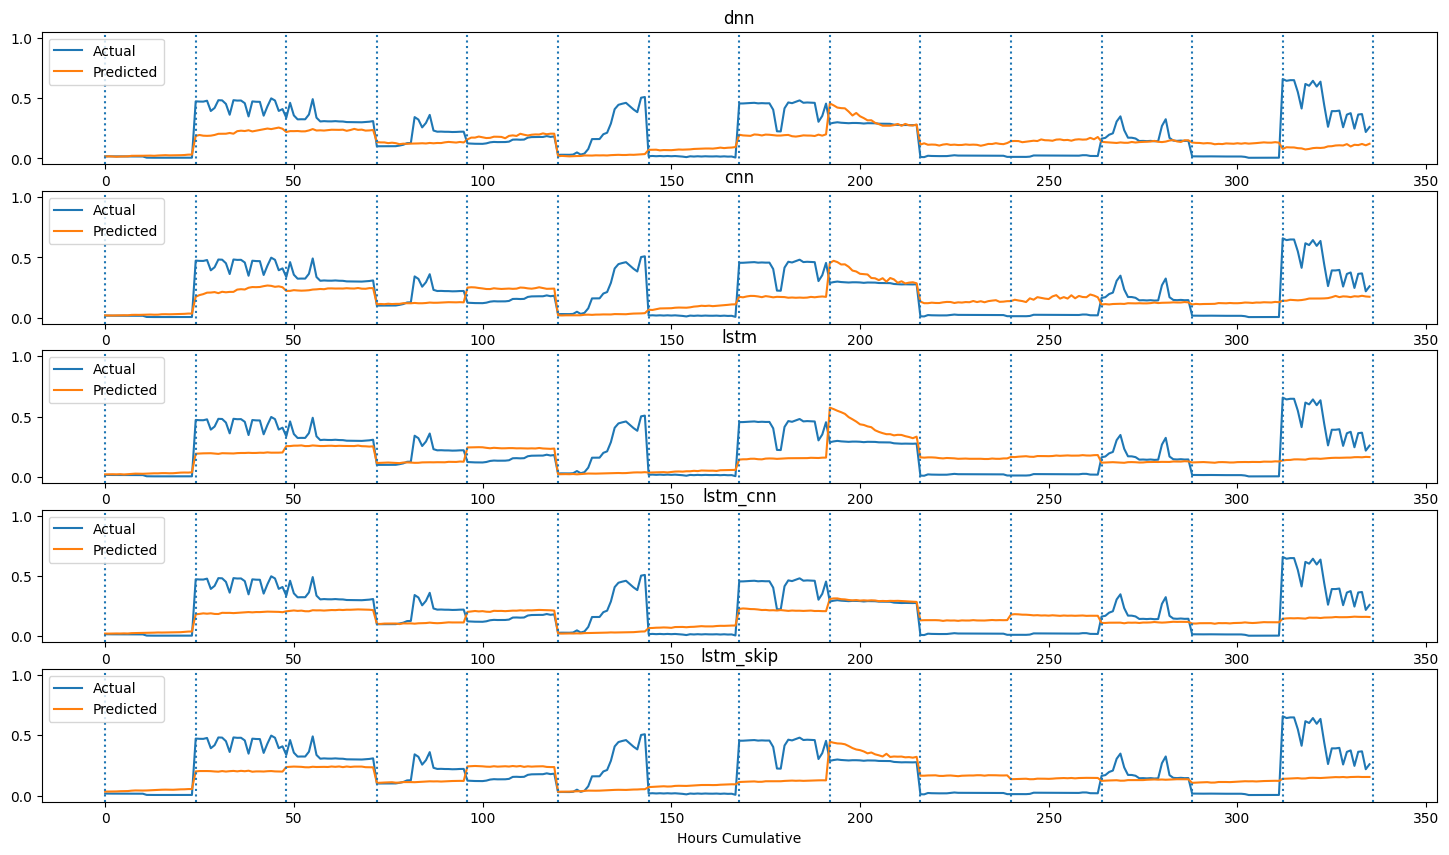

In [27]:
fig, axs = plt.subplots(5, 1, figsize=(18, 10))
days = 14

vline = np.linspace(0, days*24, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print('First Two Weeks of Predictions')